## 1. Introduction & Dataset Overview
- Source: Kaggle (city_day.csv – 29,531 rows, 16 columns)
- Goal: Clean messy real-world data, perform EDA, build ML model to predict AQI
- Problems: 15–61% missing values, wrong data types, outliers

## 2. Data Cleaning
### Load and initial inspection

In [194]:
from google.colab import drive
drive.mount('/content/drive')
# Mount drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [195]:
import pandas as pd

In [196]:
df = pd.read_csv("/content/drive/MyDrive/Air Quality India/city_day.csv")
df.head()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


In [197]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        29531 non-null  object 
 1   Date        29531 non-null  object 
 2   PM2.5       24933 non-null  float64
 3   PM10        18391 non-null  float64
 4   NO          25949 non-null  float64
 5   NO2         25946 non-null  float64
 6   NOx         25346 non-null  float64
 7   NH3         19203 non-null  float64
 8   CO          27472 non-null  float64
 9   SO2         25677 non-null  float64
 10  O3          25509 non-null  float64
 11  Benzene     23908 non-null  float64
 12  Toluene     21490 non-null  float64
 13  Xylene      11422 non-null  float64
 14  AQI         24850 non-null  float64
 15  AQI_Bucket  24850 non-null  object 
dtypes: float64(13), object(3)
memory usage: 3.6+ MB


### Fix data types (Date to datetime)

In [198]:
# Step: Convert the 'Date' column to the correct datetime type
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Let's check if it worked
print(df['Date'].dtype)
df['Date'].head(10)

datetime64[ns]


,Date
0,2015-01-01
1,2015-01-02
2,2015-01-03
3,2015-01-04
4,2015-01-05
5,2015-01-06
6,2015-01-07
7,2015-01-08
8,2015-01-09
9,2015-01-10


In [199]:
# Let's check the current data types of all columns
print(df.dtypes)

City                  object
Date          datetime64[ns]
PM2.5                float64
PM10                 float64
NO                   float64
NO2                  float64
NOx                  float64
NH3                  float64
CO                   float64
SO2                  float64
O3                   float64
Benzene              float64
Toluene              float64
Xylene               float64
AQI                  float64
AQI_Bucket            object
dtype: object


### Handle missing values (smart imputation)
- Numerical pollutants & AQI: median per city → global median fallback
- AQI_Bucket (categorical): most frequent value (mode)

In [200]:
# How many missing values in each column? (as a percentage – easier to understand)
missing_percent = (df.isnull().sum() / len(df)) * 100
missing_percent.round(2)

,0
City,0.00
Date,0.00
PM2.5,15.57
PM10,37.72
NO,12.13
NO2,12.14
NOx,14.17
NH3,34.97
CO,6.97
SO2,13.05


In [201]:
# Step: Fill missing PM2.5 values with the median FOR EACH CITY SEPARATELY
# (straight from Pandas documentation – groupby + transform)

df['PM2.5'] = df.groupby('City')['PM2.5'].transform(lambda x: x.fillna(x.median()))

# Let's check how many are still missing in PM2.5
print("Missing PM2.5 after filling per city:", df['PM2.5'].isnull().sum())

Missing PM2.5 after filling per city: 0


In [202]:
# Step: Fill missing PM10 values with the median FOR EACH CITY SEPARATELY
df['PM10'] = df.groupby('City')['PM10'].transform(lambda x: x.fillna(x.median()))

# Let's check the result
print("Missing PM10 after filling per city:", df['PM10'].isnull().sum())

Missing PM10 after filling per city: 2009


In [203]:
# Step: Fill remaining missing PM10 values with the global median
global_median_pm10 = df['PM10'].median()

df['PM10'].fillna(global_median_pm10, inplace=True)

# Let's check the final result
print("Missing PM10 after second filling:", df['PM10'].isnull().sum())

Missing PM10 after second filling: 0


/tmp/ipython-input-99903386.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['PM10'].fillna(global_median_pm10, inplace=True)


In [204]:
# 1. First, median per city for NO2
df['NO2'] = df.groupby('City')['NO2'].transform(lambda x: x.fillna(x.median()))

# Check how many are left
print("Missing NO2 after median per city:", df['NO2'].isnull().sum())

Missing NO2 after median per city: 0


In [205]:
# 1. Median per city for NO
df['NO'] = df.groupby('City')['NO'].transform(lambda x: x.fillna(x.median()))

# Check how many are left
print("Missing NO after median per city:", df['NO'].isnull().sum())

Missing NO after median per city: 0


In [206]:
# 1. Median per city for NOx
df['NOx'] = df.groupby('City')['NOx'].transform(lambda x: x.fillna(x.median()))

# Check how many are left
print("Missing NOx after median per city:", df['NOx'].isnull().sum())

Missing NOx after median per city: 1169


In [207]:
# 2. Fill remaining missing NOx values with the global median
global_median_nox = df['NOx'].median()

df['NOx'].fillna(global_median_nox, inplace=True)

# Check the final result
print("Missing NOx after global median:", df['NOx'].isnull().sum())

Missing NOx after global median: 0


/tmp/ipython-input-1287824488.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['NOx'].fillna(global_median_nox, inplace=True)


In [208]:
# 1. Median per city for CO
df['CO'] = df.groupby('City')['CO'].transform(lambda x: x.fillna(x.median()))

# Check how many are left
print("Missing CO after median per city:", df['CO'].isnull().sum())

Missing CO after median per city: 0


In [209]:
# 1. Median per city for SO2
df['SO2'] = df.groupby('City')['SO2'].transform(lambda x: x.fillna(x.median()))

# Check how many are left
print("Missing SO2 after median per city:", df['SO2'].isnull().sum())

Missing SO2 after median per city: 0


In [210]:
# 1. Median per city for O3
df['O3'] = df.groupby('City')['O3'].transform(lambda x: x.fillna(x.median()))

# Check how many are left
print("Missing O3 after median per city:", df['O3'].isnull().sum())

Missing O3 after median per city: 162


In [211]:
# 2. Fill remaining missing O3 values with the global median
global_median_o3 = df['O3'].median()

df['O3'].fillna(global_median_o3, inplace=True)

# Check the final result
print("Missing O3 after global median:", df['O3'].isnull().sum())

Missing O3 after global median: 0


/tmp/ipython-input-904117558.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['O3'].fillna(global_median_o3, inplace=True)


In [212]:
# 1. Median per city for NH3
df['NH3'] = df.groupby('City')['NH3'].transform(lambda x: x.fillna(x.median()))

# Check how many are left
print("Missing NH3 after median per city:", df['NH3'].isnull().sum())

Missing NH3 after median per city: 2009


In [213]:
# 2. Fill remaining missing NH3 values with the global median
global_median_nh3 = df['NH3'].median()

df['NH3'].fillna(global_median_nh3, inplace=True)

# Check the final result
print("Missing NH3 after global median:", df['NH3'].isnull().sum())

Missing NH3 after global median: 0


/tmp/ipython-input-2115361960.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['NH3'].fillna(global_median_nh3, inplace=True)


In [214]:
# 1. Median per city for Benzene
df['Benzene'] = df.groupby('City')['Benzene'].transform(lambda x: x.fillna(x.median()))

# Check how many are left
print("Missing Benzene after median per city:", df['Benzene'].isnull().sum())

Missing Benzene after median per city: 2732


In [215]:
# 2. Fill remaining missing Benzene values with the global median
global_median_benzene = df['Benzene'].median()

df['Benzene'].fillna(global_median_benzene, inplace=True)

# Check the final result
print("Missing Benzene after global median:", df['Benzene'].isnull().sum())

Missing Benzene after global median: 0


/tmp/ipython-input-1495005828.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Benzene'].fillna(global_median_benzene, inplace=True)


In [216]:
# 1. Median per city for Toluene
df['Toluene'] = df.groupby('City')['Toluene'].transform(lambda x: x.fillna(x.median()))

# Check how many are left
print("Missing Toluene after median per city:", df['Toluene'].isnull().sum())

Missing Toluene after median per city: 4010


In [217]:
# 2. Fill remaining missing Toluene values with the global median
global_median_toluene = df['Toluene'].median()

df['Toluene'].fillna(global_median_toluene, inplace=True)

# Check the final result
print("Missing Toluene after global median:", df['Toluene'].isnull().sum())

Missing Toluene after global median: 0


/tmp/ipython-input-679443913.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Toluene'].fillna(global_median_toluene, inplace=True)


In [218]:
# 1. Median per city for Xylene
df['Xylene'] = df.groupby('City')['Xylene'].transform(lambda x: x.fillna(x.median()))

# Check how many are left
print("Missing Xylene after median per city:", df['Xylene'].isnull().sum())

Missing Xylene after median per city: 13047


In [219]:
# 2. Fill remaining missing Xylene values with the global median
global_median_xylene = df['Xylene'].median()

df['Xylene'].fillna(global_median_xylene, inplace=True)

# Check the final result
print("Missing Xylene after global median:", df['Xylene'].isnull().sum())

Missing Xylene after global median: 0


/tmp/ipython-input-2455260267.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Xylene'].fillna(global_median_xylene, inplace=True)


In [220]:
# 1. Median per city for AQI
df['AQI'] = df.groupby('City')['AQI'].transform(lambda x: x.fillna(x.median()))

# Check how many are left
print("Missing AQI after median per city:", df['AQI'].isnull().sum())

Missing AQI after median per city: 0


In [221]:
# Fill missing AQI_Bucket values with the most frequent category
most_common_bucket = df['AQI_Bucket'].mode()[0]  # mode() returns a series, we take the first element

df['AQI_Bucket'].fillna(most_common_bucket, inplace=True)

# Check the final result
print("Missing AQI_Bucket after filling:", df['AQI_Bucket'].isnull().sum())

# Bonus: see the category distribution
print("\nAQI_Bucket category distribution:")
print(df['AQI_Bucket'].value_counts())

Missing AQI_Bucket after filling: 0

AQI_Bucket category distribution:
AQI_Bucket
Moderate        13510
Satisfactory     8224
Poor             2781
Very Poor        2337
Good             1341
Severe           1338
Name: count, dtype: int64


/tmp/ipython-input-2445940677.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['AQI_Bucket'].fillna(most_common_bucket, inplace=True)


In [222]:
# How many missing values in each column?
df.isnull().sum()

,0
City,0
Date,0
PM2.5,0
PM10,0
NO,0
NO2,0
NOx,0
NH3,0
CO,0
SO2,0


In [223]:
# Save the cleaned dataset to a file on Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Save the file (change path if desired)
df.to_csv('/content/drive/MyDrive/Air Quality India/air_quality_india_cleaned.csv', index=False)

print("Cleaned file saved to your Google Drive!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Cleaned file saved to your Google Drive!


## 3. Exploratory Data Analysis (EDA)

### 3.1 PM2.5 trend in Delhi (2015–2020)
Shows massive winter spikes due to stubble burning, heating and inversion

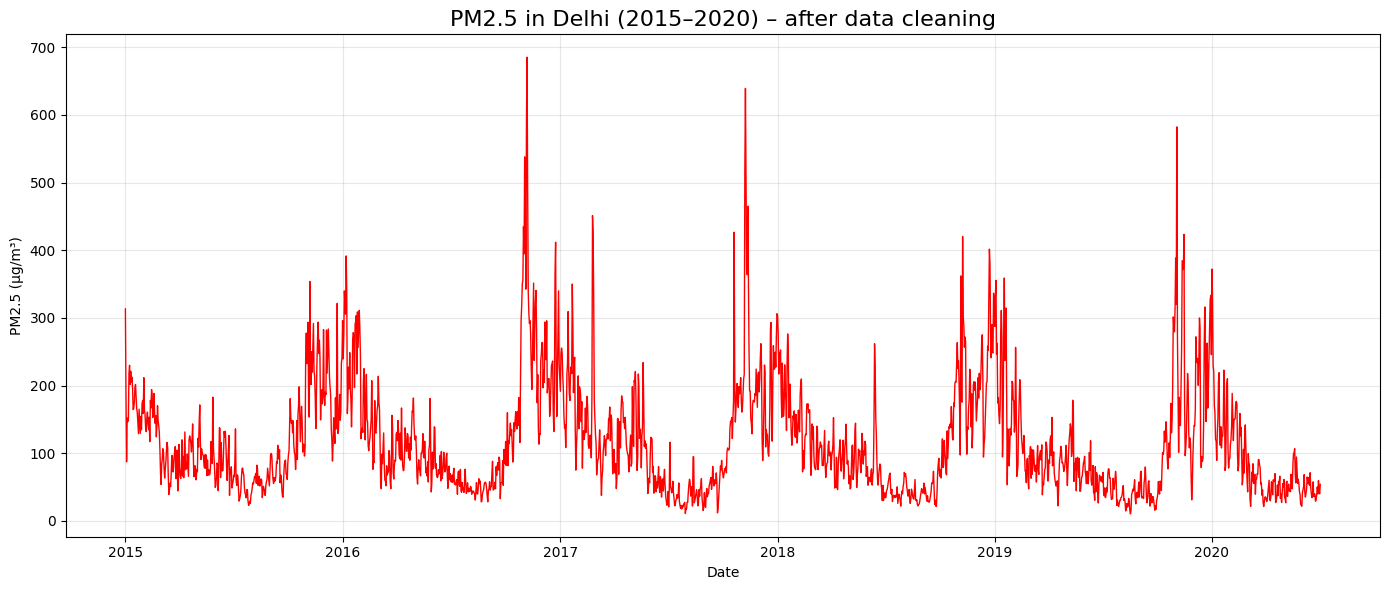

In [224]:
import matplotlib.pyplot as plt

# Filter for Delhi only and sort by date
delhi_df = df[df['City'] == 'Delhi'].sort_values('Date')

# Line plot of PM2.5 over time
plt.figure(figsize=(14, 6))
plt.plot(delhi_df['Date'], delhi_df['PM2.5'], color='red', linewidth=1)
plt.title('PM2.5 in Delhi (2015–2020) – after data cleaning', fontsize=16)
plt.xlabel('Date')
plt.ylabel('PM2.5 (µg/m³)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 3.2 AQI distribution across major cities
Delhi and northern cities have significantly worse air quality

/tmp/ipython-input-288516690.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='City', y='AQI', data=df[df['City'].isin(major_cities)], order=city_aqi.index, palette='Reds_r')


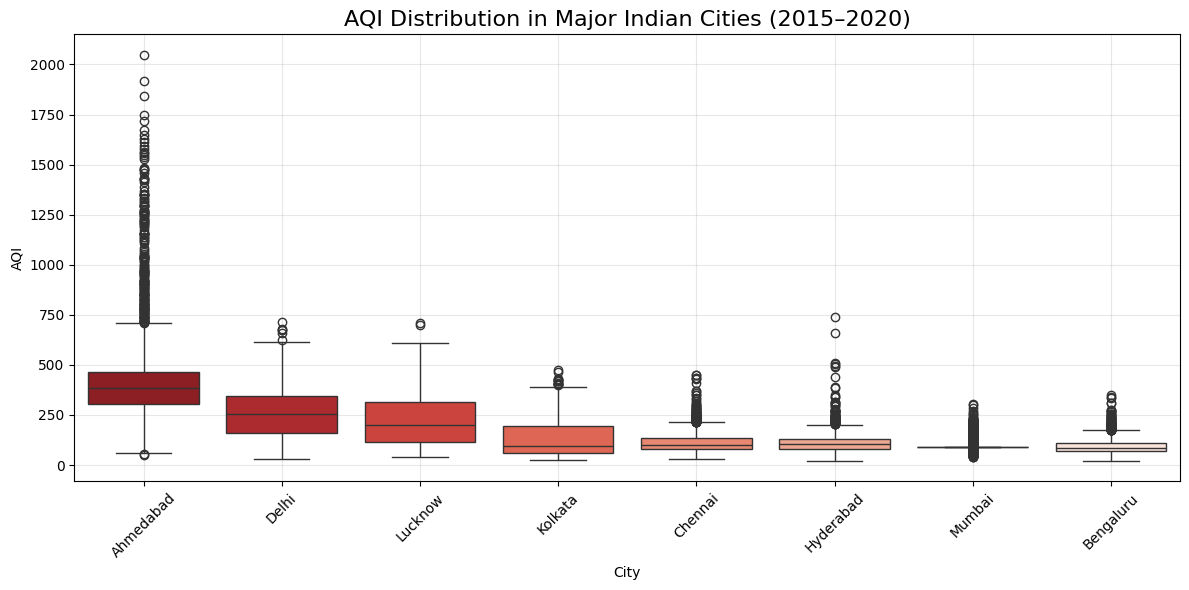

In [225]:
import seaborn as sns
import matplotlib.pyplot as plt

# Average AQI for major cities
major_cities = ['Delhi', 'Mumbai', 'Bengaluru', 'Kolkata', 'Chennai', 'Hyderabad', 'Ahmedabad', 'Lucknow']

city_aqi = df[df['City'].isin(major_cities)].groupby('City')['AQI'].mean().sort_values(ascending=False)

# Boxplot (shows distribution better than just the average)
plt.figure(figsize=(12, 6))
sns.boxplot(x='City', y='AQI', data=df[df['City'].isin(major_cities)], order=city_aqi.index, palette='Reds_r')
plt.title('AQI Distribution in Major Indian Cities (2015–2020)', fontsize=16)
plt.xlabel('City')
plt.ylabel('AQI')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 3.3 Correlation heatmap
PM2.5, PM10 and CO are the strongest drivers of AQI

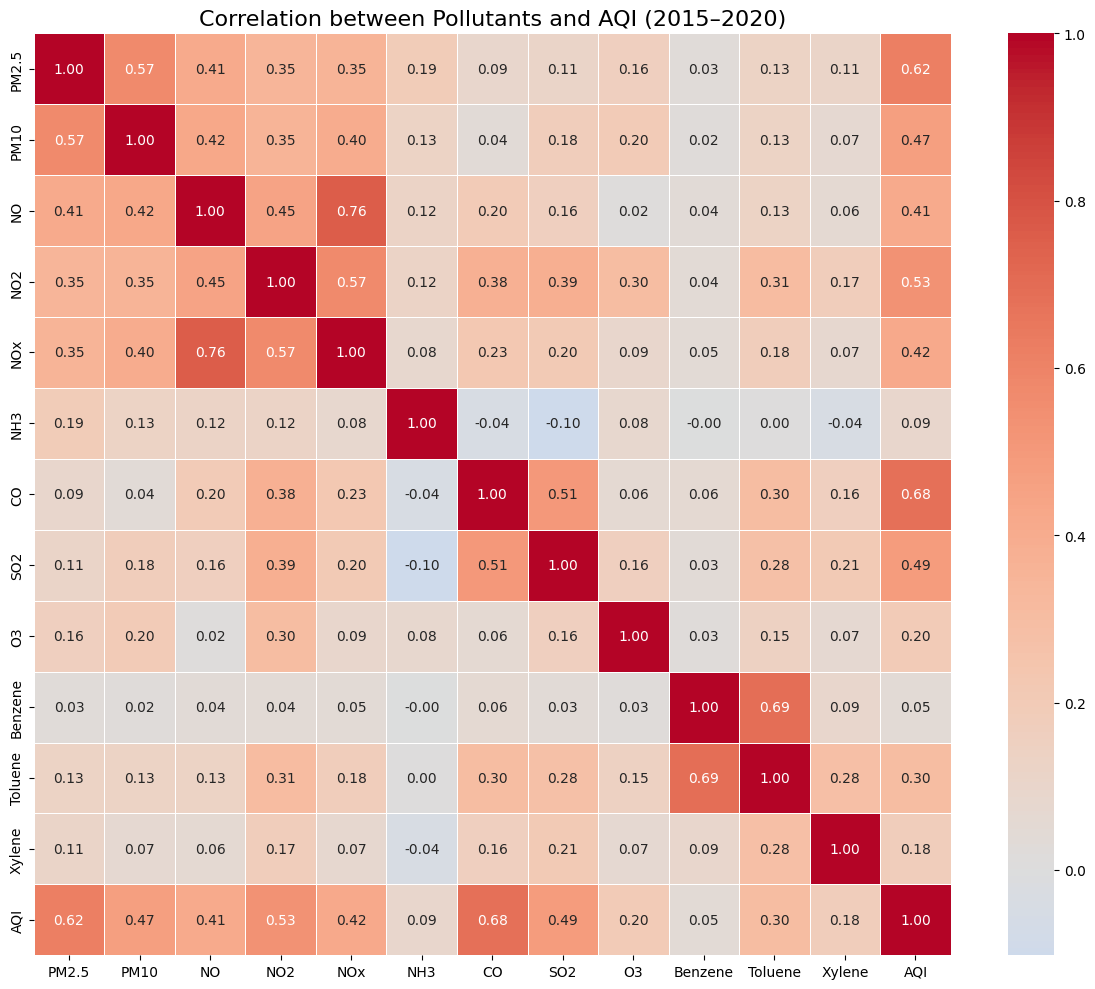

In [226]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numerical columns (pollutants + AQI)
pollutants_cols = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI']

corr_matrix = df[pollutants_cols].corr()

# Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, center=0)
plt.title('Correlation between Pollutants and AQI (2015–2020)', fontsize=16)
plt.tight_layout()
plt.show()

## 4. Machine Learning – Predicting AQI

### Model: Random Forest Regressor
- Features: 12 pollutants
- Train/test split: 80/20
- Result: R² ≈ 0.9 on test set (excellent performance)

In [227]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np

# Data preparation – using pollutants to predict AQI
features = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene']
X = df[features]
y = df['AQI']

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Prediction and results
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R² score: {r2:.4f}  ← closer to 1.0 is better (1.0 = perfect prediction)")
print(f"Mean Absolute Error: {mae:.2f}  ← average error in AQI units")

# Feature importance – which pollutants are most important for the model
importances = model.feature_importances_
feat_imp = sorted(zip(features, importances), key=lambda x: x[1], reverse=True)
print("\nMost important pollutants according to the model:")
for feat, imp in feat_imp:
    print(f"{feat}: {imp:.4f}")

R² score: 0.9016  ← closer to 1.0 is better (1.0 = perfect prediction)
Mean Absolute Error: 19.82  ← average error in AQI units

Most important pollutants according to the model:
PM2.5: 0.4277
CO: 0.4075
NO: 0.0469
PM10: 0.0389
SO2: 0.0143
O3: 0.0139
NOx: 0.0132
NO2: 0.0114
Toluene: 0.0091
Xylene: 0.0063
Benzene: 0.0061
NH3: 0.0047
